# Pre note:

Install pytorch, torchsummary

Install matplotlib, pandas, tqdm

# Load data

In [6]:
import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from tqdm import tqdm
file_dir = 'YOU FOLDER PATH'
# ensure the xxx-array.pkl is there
process="vbf"

with open(file_dir+f'{process}-array.pkl', 'rb') as f:
    _towers = pickle.load(f)
towers=_towers[:70000,...]
val_towers=_towers[70000:,...]
print(towers.shape)

with open(file_dir+f'{process}-met-array.pkl', 'rb') as f:
    _met_all = pickle.load(f)
tru_met_met=_met_all[:70000,...,2]
val_tru_met_met=_met_all[70000:,...,2]

(70000, 98, 64)


In [7]:
import torch
from torchsummary import summary
dev=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Running on",dev)
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from functools import partial
import math

Running on cuda:0


In [8]:
# Create the bins and weights, this is related to the reweighting and data augmentation
met_bins, edges = np.histogram(tru_met_met, bins=30, range=(10, 400), density=True)
weights = [max(met_bins) / float(x) for x in met_bins]

def get_weight(m, weights, edges):
    if m > edges[-1]:
        return weights[-1]
    else:
        idx = np.digitize([m], edges)[0][0]
        return weights[idx-1]

def add_phi_shift_shuffle(towers, mets):
    while True:
        idx = np.random.randint(0, len(towers))
        m = mets[idx]
        if m>10:
            t = towers[idx]
            shift = np.random.randint(1, 64)
            t_prime = np.roll(t, shift, axis=2)
            w = get_weight(m, weights, edges) 
            return t_prime, m, w

# # Reshape the towers and mets for CNN input
train_images =   towers[:,None,:,:]        
train_truth =  tru_met_met[:,None]        

test_images =   val_towers[:,None,:,:]        
test_truth =  val_tru_met_met[:,None]  

# Custom Dataset class
class METDataset(Dataset):
    def __init__(self, images, truth, shuffle=True):
        self.images = images
        self.truth = truth
        self.shuffle=shuffle

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.shuffle:
            t, m, w = add_phi_shift_shuffle(self.images, self.truth)
        else:
            t, m, w = self.images[idx], self.truth[idx], 1
        t = torch.tensor(t, dtype=torch.float32)
        m = torch.tensor(m, dtype=torch.float32)
        w = torch.tensor(w, dtype=torch.float32)
        return t, m, w

In [9]:
# Creat the dataloader
train_dataset = METDataset(train_images, train_truth)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
# the validation dataset: used to monitor the model
msk=(test_truth>0)
msk=msk[:,0]
val_dataset = METDataset(test_images[msk,:,:,:], test_truth[msk,:], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Prepare Model

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=15, kernel_size=9) # 98x64x1 input
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=20, kernel_size=7)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=25, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=25, out_channels=1, kernel_size=1)
        BINS=np.linspace(-np.pi,np.pi,19)
        BINS=(BINS[:-1]+BINS[1:])/2
        grid_cos=np.cos(BINS)
        grid_sin=np.sin(BINS)
        self.cosPHI=nn.Parameter(torch.Tensor(grid_cos),requires_grad=False)
        self.sinPHI=nn.Parameter(torch.Tensor(grid_sin),requires_grad=False)
        
        for m in [self.conv1,self.conv2,self.conv3,self.conv4]:
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Conv2D -> ReLU .double()
        x = self.pool(x)           # MaxPooling
        x = F.relu(self.conv2(x))  # Conv2D -> ReLU
        x = F.relu(self.conv3(x))  # Conv2D -> ReLU
        x = F.relu(self.conv4(x))  # Conv2D -> ReLU
        x1=(x*self.cosPHI).sum([-1,-2])
        x2=(x*self.sinPHI).sum([-1,-2])
        x = torch.sqrt(x1**2 + x2**2)
        return x

In [17]:
def MAPE(y_pred,y_true):
    epsilon = torch.Tensor([1e-7]).to(dev)
    diff = torch.abs((y_true - y_pred) / torch.maximum(torch.abs(y_true), epsilon))
    return 100.0 * torch.mean(diff, axis=-1)

In [18]:
criterion = MAPE

# Let's train it

In [19]:
# define the monitor function: to monitor the performance during training
def plot_eval(_tru,_test,thre=20,max_e=500,display=False):
    if len(_tru.shape)==2:
        _tru=_tru.flatten()
    if len(_test.shape)==2:
        _test=_test.flatten()
    assert _tru.shape==_test.shape
    msk=_tru>thre if thre else np.ones_like(_tru).astype(bool)
    tru=_tru[msk]
    test=_test[msk]
    fig,axs=plt.subplots(1,6,figsize=(20,4))
    ax=axs[0]
    ax.hist2d(_tru,_test,bins=100,range=[[0,1000],[0,1000]],norm=LogNorm())
    ax=axs[3]
    ax.hist2d(tru,test/tru,bins=100,range=[[thre,max_e],[0,3]],norm=LogNorm())
    ax=axs[2]
    _,bins,_=ax.hist(tru,bins=100,log=True,label="truth(above th)")
    ax.hist(test,bins=bins,log=True,label="output",alpha=0.5)
    ax.legend()
    # profile
    ax=axs[4]
    D=pd.DataFrame([tru,test]).T
    D["bin"]=np.digitize(D[0],np.linspace(thre,max_e,50))
    D["r"]=D[1]/D[0]
    G=D.groupby("bin")["r"].agg(["mean","std"])
    ax.errorbar(G.index * 10,G["mean"],G["std"])
    ax.set_ylim(0,3)
    ax.axhline(y=1,c="red",ls="--")
    ax=axs[1]
    _,bins,_=ax.hist(_tru[~msk],bins=100,range=[0,thre if thre else 20],log=True,label="truth(below th)")
    ax.hist(_test[~msk],bins=bins,log=True,label="output",alpha=0.5)
    ax.legend()
    ax=axs[5]
    _,bins,_=ax.hist(_tru[~msk],bins=100,range=[0,max_e],log=True,label="truth(below th)")
    ax.hist(_test[~msk],bins=bins,log=True,label="output",alpha=0.5)
    ax.legend()
    del G
    del tru
    del test
    if display:
        plt.show()
    else:
        return fig,axs  

In [20]:
model=CNN().to(dev)
optimizer = optim.Adam(model.parameters(),lr=1e-3, eps=1e-7)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    i_step=0
    for towers_batch, mets_batch, weights_batch in train_loader:
        # Move data to the correct device (GPU or CPU)
        towers_batch = towers_batch.to(dev)
        mets_batch = mets_batch.to(dev)
        weights_batch = weights_batch.to(dev)
        # Forward pass
        outputs = model(towers_batch)  # Assuming your model outputs the predicted MET
        loss = criterion(outputs, mets_batch)  # Compute loss for each sample in the batch
        
        # Apply the weights to the loss
        weighted_loss = loss * weights_batch  # Element-wise multiplication by the weights
        weighted_loss = weighted_loss.mean()  # Take the mean to get a single scalar value
#         
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        weighted_loss.backward()  # Backpropagate with the weighted loss
        optimizer.step()  # Update model parameters
        
        running_loss += weighted_loss.item()
        if i_step>100:
            break
            
        i_step+=1
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradients during validation
        coll_val=[]
        for towers_batch, mets_batch, weights_batch in val_loader:
            towers_batch = towers_batch.to(dev)
            mets_batch = mets_batch.to(dev)
            weights_batch = weights_batch.to(dev)
            outputs = model(towers_batch)
            loss = criterion(outputs, mets_batch)  # Compute loss for each sample
            weighted_loss = loss * weights_batch
            weighted_loss = weighted_loss.mean()  # Mean to get a scalar loss
            val_loss += weighted_loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(val_loader)}")    

Epoch [1/10], Loss: 30.625235246930803
Epoch [1/10], Validation Loss: 65.86620586614873
Epoch [2/10], Loss: 25.721116060529436
Epoch [2/10], Validation Loss: 56.67505167084716
Epoch [3/10], Loss: 23.544343207223076
Epoch [3/10], Validation Loss: 55.08903943043528
Epoch [4/10], Loss: 21.322368872506278
Epoch [4/10], Validation Loss: 54.99118548313946
Epoch [5/10], Loss: 23.467508523123605
Epoch [5/10], Validation Loss: 57.40195185899226
Epoch [6/10], Loss: 20.613230699811663
Epoch [6/10], Validation Loss: 52.07288578781746
Epoch [7/10], Loss: 20.431603491646904
Epoch [7/10], Validation Loss: 49.25601827462853
Epoch [8/10], Loss: 21.567142464773994
Epoch [8/10], Validation Loss: 50.67403545460976
Epoch [9/10], Loss: 19.868769694737026
Epoch [9/10], Validation Loss: 48.505438046160535
Epoch [10/10], Loss: 21.897826113019672
Epoch [10/10], Validation Loss: 50.9997869239433


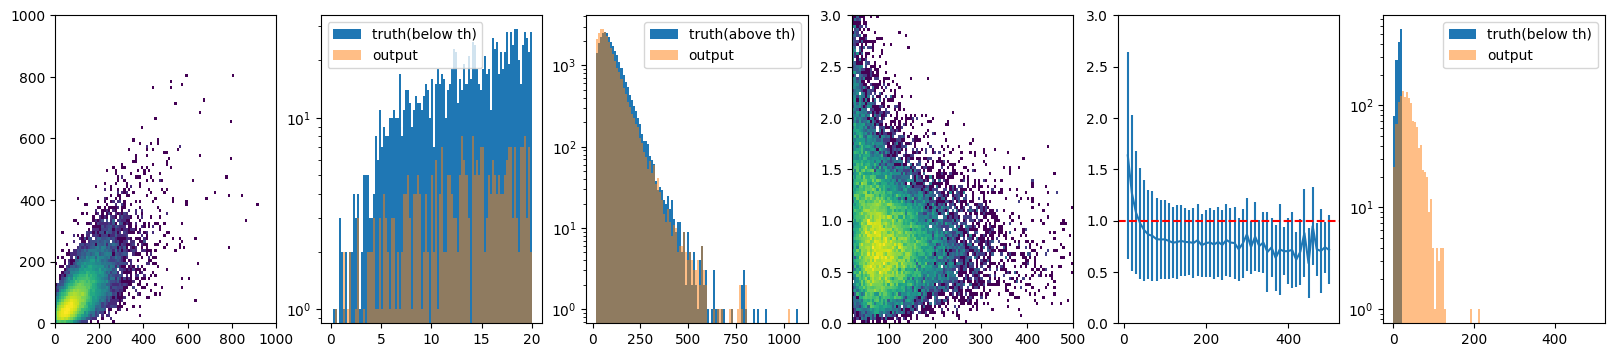

In [21]:
# plot the results
model.eval()  # Set model to evaluation mode
val_loss = 0.0
with torch.no_grad():  # No gradients during validation
    coll_val=[]
    for towers_batch, mets_batch, weights_batch in val_loader:
        towers_batch = towers_batch.to(dev)
        mets_batch = mets_batch.to(dev)
        weights_batch = weights_batch.to(dev)
        outputs = model(towers_batch)
        # collect the results
        coll_val.append(outputs.numpy(force=True))
    coll_val=np.concatenate(coll_val,axis=0)
    plot_eval(val_tru_met_met[msk],coll_val,display=True)

In [ ]:
# Homework1: how many layers in the network, how many parameter in the model, what is the input, what is the output
# you answer:

In [ ]:
# Homework2: what is the loss function?
# you answer:

In [ ]:
# Homework3: can you draw the plot shown the histogramed MET distribution obtained by the network, and the histogramed MET distribution from truth? Which plot (in this six) showing ths?
# you answer:

In [ ]:
# Homework4: can you draw the plot shown MET distribution obtained by the network divided by the truth MET? Which plot (in this six) showing ths?
# you answer: